# 1-Step SARSA 

This notebook shows the tabular reinforcement learning algorithm, 1-step SARSA applied to the Taxi problem (it also works on CliffWalking and FrozenLake) from Open AI's gym. 1-step SARSA is an on-policy Temporal Difference control algorithm. The algorithm is defined by: 
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q(S_{t + 1}, A_{t + 1}) - Q(S_t, A_t)]$$
, where $Q$ is the learned action-value function, $R$ is the reward, $A$ is the action, $\alpha$ is the step size, $\gamma$ is the discount rate and $t$ is the time step.

For more information on the SARSA algorithm see section 6.4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of 1-step SARSA see: [SARSA Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/TD/SARSA%20Solution.ipynb).

In [24]:
import os
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import matplotlib.pyplot as plt

In [25]:
# Type of environment, options include:
# Taxi-v3, CliffWalking-v0, FrozenLake-v1
ENV_TYPE = "Taxi-v3"

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/sarsa/'

In [26]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
Q = np.zeros([num_states, num_actions])

## Create An $\epsilon$-Greedy Policy 

In [27]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Find the best action
    best_action = np.argmax(Q[state, :])
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [28]:
# Number of episodes to train on
episodes = 401
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.618
# Probability of taking a non-greedy action
epsilon = 0.001

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 100 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )


for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0
    state, info = env.reset()
    action_dist = policy_fn(state, Q, epsilon, num_actions)
    action = np.random.choice(np.arange(num_actions), p=action_dist)

    while not terminated:
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        # Select the next action following the epsilon-greedy policy
        next_action_dist = policy_fn(next_state, Q, epsilon, num_actions)
        next_action = np.random.choice(np.arange(num_actions), p=next_action_dist)
        # Update the expected return for the action-value function
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action]) 
        state = next_state
        action = next_action
    
    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.return_queue).flatten()[-episode_window:]) :.2f}')

Episode 5 Average Returns: 3.20
Episode 10 Average Returns: 3.20
Episode 15 Average Returns: -25.00
Episode 20 Average Returns: -20.60
Episode 25 Average Returns: -32.20
Episode 30 Average Returns: -13.80
Episode 35 Average Returns: -75.80
Episode 40 Average Returns: -71.40
Episode 45 Average Returns: -116.80
Episode 50 Average Returns: 3.20
Episode 55 Average Returns: -86.80
Episode 60 Average Returns: -83.60
Episode 65 Average Returns: 2.60
Episode 70 Average Returns: -53.60
Episode 75 Average Returns: -77.60
Episode 80 Average Returns: -31.60
Episode 85 Average Returns: -44.80
Episode 90 Average Returns: -56.00
Episode 95 Average Returns: -40.00
Episode 100 Average Returns: -25.00
Episode 105 Average Returns: -14.00
Episode 110 Average Returns: -35.20
Episode 115 Average Returns: -43.80
Episode 120 Average Returns: -19.20
Episode 125 Average Returns: -19.00
Episode 130 Average Returns: -21.00
Episode 135 Average Returns: 2.00
Episode 140 Average Returns: -64.00
Episode 145 Average R

## Plot The Results

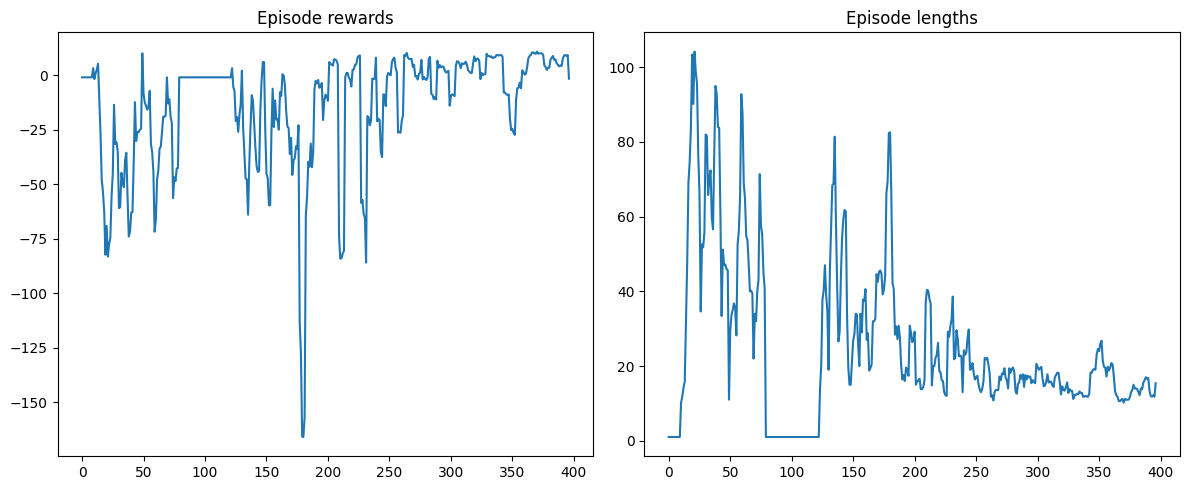

In [29]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [30]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 100

In [31]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-100.mp4")

### Episode 200

In [32]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-200.mp4")

### Episode 300

In [33]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-300.mp4")

### Episode 400

In [34]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-400.mp4")

## Render Final Model On An Example

In [35]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(ENV_TYPE, render_mode="human")
state, info = env.reset(seed=60)
G = 0
num_steps = 0
terminated = False
truncated = False

while not terminated and not truncated:
    action = np.argmax(Q[state, :]) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: 9, Steps Taken: 12
